In [2]:
from torchvision.transforms import RandomCrop
from torchvision.transforms.functional import resize, center_crop, pad
import torch
import math

class RandomCenterCrop(torch.nn.Module): 
    def __init__(self, min_ratio: float, max_ratio: float): 
        super().__init__()
        self.min_ratio = min_ratio
        self.max_ratio = max_ratio 
        assert min_ratio < max_ratio
        
    def forward(self, image): 
        _, _, H, W = image.shape
        min_size = math.floor(H*self.min_ratio)
        max_size = math.ceil(H*self.max_ratio)
        
        new_size = torch.randint(min_size, max_size, (1, 1)).item()
        image = resize(image, new_size)
        image = center_crop(image, (H, W))
        return image


In [7]:
import matplotlib.pyplot as plt
def show_image(image): 
    plt.figure()
    return plt.imshow(image.permute(1, 2, 0))

In [ ]:
## load image dataset 
from hydra.utils import instantiate 
from hydra import initialize, compose

with initialize("../configs"): 
    dataset = instantiate(compose("val_dataset/imagenette_val.yaml")).val_dataset


In [3]:
from ffcv.loader import Loader
from ffcv.transforms import ToTensor
from ffcv.fields import JSONField
from ffcv.fields.decoders import IntDecoder, CenterCropRGBImageDecoder, BytesDecoder, NDArrayDecoder
from ffcv.pipeline.pipeline_spec import PipelineSpec
import numpy as np
import ftfy

def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a corresponding list of unicode strings.
    The reversible bpe codes work on unicode strings.
    This means you need a large # of unicode characters in your vocab if you want to avoid UNKs.
    When you're at something like a 10B token dataset you end up needing around 5K for decent coverage.
    This is a signficant percentage of your normal, say, 32K bpe vocab.
    To avoid that, we want lookup tables between utf-8 bytes and unicode strings.
    And avoids mapping to whitespace/control characters the bpe code barfs on.
    """
    bs = list(range(ord("!"), ord("~")+1))+list(range(ord("¡"), ord("¬")+1))+list(range(ord("®"), ord("ÿ")+1))
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8+n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))
cache = bytes_to_unicode()

In [4]:
debug_loader = Loader('/mnt/cfs/datasets/yfcc100m_out/yfcc_clip_debug.beton',
                batch_size=1,
                num_workers=2,
                pipelines={
                  'image': PipelineSpec('image', 
                                        CenterCropRGBImageDecoder((224, 224), 1.0),
                                        [ToTensor()]),
                  'text': PipelineSpec('text', 
                                        NDArrayDecoder(), [])
                })

In [15]:
dset = iter(debug_loader)

In [192]:
import mmap 

def process_image(idx): 
    alloc_entry = loader.reader.alloc_table[idx]
    size = alloc_entry["size"]
    ptr = alloc_entry["ptr"]
    sample_id = alloc_entry["sample_id"]
    metadata = loader.reader.metadata[sample_id]
    mmap = np.memmap('/mnt/cfs/datasets/yfcc100m_out/yfcc.beton',
                                  'uint8', mode='r')
    return mmap[ptr:ptr+size], metadata

In [173]:
im, metadata = process_image(2)


In [145]:
metadata

((0, 500, 375, 2995119417), (2995173473, 1079))

In [50]:
500 * 333

166500

800
0
Abstract Colors changed. architecture, blue, ceiling, curve, ginza, glass, light, line, pillar, reflection, tanakawho


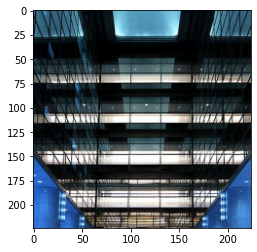

In [67]:
max_iter = 1e5
i = 0 
while i < max_iter: 
    im, metadatas = next(dset)
    metadata = metadatas[0]
    #print(metadata)
    print(metadata.size)
    idx = metadata.argmin()
    metadata = metadata[:idx].tobytes()
    if im[0].max() > 0: 
        plt.figure()
        plt.imshow(im[0])
        print(i)
        print(metadata.decode('utf-8'))
        break 
    i += 1

In [233]:
s = b"Tournament of Champions Annual squash tournament in Grand Central Terminal \x00around 1990 cameraphone, kodachrome\x00 failure (see ), Stinson's next brilliant idea: Forget about using the existing unoccupied buildings in favour of knocking down occupied buildings to build hotel-condos next door to the abandoned hotel he also owns... wait, what? Hotel-condos are flopping in Toronto, why would they succeed in Hamilton? condo, connaught, ghogday2009, grand, groundhog day, hamilton, hotel, hotel-condo, john, ontario, royal, street"

In [212]:
s.decode('utf-8')

"Tournament of Champions Annual squash tournament in Grand Central Terminal \x00around 1990 cameraphone, kodachrome\x00 failure (see ), Stinson's next brilliant idea: Forget about using the existing unoccupied buildings in favour of knocking down occupied buildings to build hotel-condos next door to the abandoned hotel he also owns... wait, what? Hotel-condos are flopping in Toronto, why would they succeed in Hamilton? condo, connaught, ghogday2009, grand, groundhog day, hamilton, hotel, hotel-condo, john, ontario, royal, street"

In [149]:
import numpy as np
loader.reader.metadata[249826].dtype

dtype([('f0', [('mode', 'u1'), ('width', '<u2'), ('height', '<u2'), ('data_ptr', '<u8')]), ('f1', [('ptr', '<u8'), ('size', '<u8')])], align=True)

In [134]:
loader.reader.alloc_table[:10]

array([(249826, 2994733056, 56208), (249826, 2994789264,   810),
       (249827, 2994790074, 80685), (249827, 2994870759,   792),
       (249828, 2994871551, 92465), (249828, 2994964016,   746),
       (249829, 2994964762, 20878), (249829, 2994985640,  1071),
       (249830, 2994986711, 43188), (249830, 2995029899,   713)],
      dtype=[('sample_id', '<u8'), ('ptr', '<u8'), ('size', '<u8')])

In [1]:
loader.reader.metadata.max()

NameError: name 'loader' is not defined

In [17]:
print(len(loader))
plt.figure().clear()
plt.close()
plt.cla()
plt.clf()

96956162


<Figure size 432x288 with 0 Axes>

In [29]:
loader.reader.metadata.dtype.itemsize * len(loader.reader.metadata) 

2811728698

In [ ]:
JSONField.unpack(label)

In [ ]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=5)

# grab 1 batch 
for b in dataloader: 
    image, y = b
    break


In [ ]:
aug = RandomCenterCrop(1.99, 2)
augmented = aug(image)

In [ ]:
show_image(augmented[0])
show_image(image[0])

In [ ]:
print(image.shape)
B, _, H, W = image.shape
show_image(image[0])
grids = rearrange(image, 'b c (hs h) (ws w) -> b (hs ws) c h w', hs=4, ws=4)
show_image(grids[0][0])
show_image(grids[0][1])
# # generate shuffle indices 
indices = torch.argsort(torch.rand((B, 16)), dim=-1)
# # shuffle the jigsaw 
grids = grids[torch.arange(B).unsqueeze(-1),indices, :, :, :]
grids = rearrange(grids, 'b (hs ws) c h w -> b c (hs h) (ws w)', hs=4, ws=4)
show_image(grids[0])

In [ ]:
from torchvision.transforms import RandomCrop
from torchvision.transforms.functional import pad
import torch

class CropAndShift(torch.nn.Module): 
    def __init__(self, crop_size: int, shift: bool): 
        super().__init__()
        self.crop = RandomCrop(crop_size)
        self.crop_size = crop_size
        self.shift = shift
        
    def forward(self, image): 
        _, _, H, W = image.shape
        assert H > self.crop_size 
        assert W > self.crop_size
        
        image = self.crop(image)
        x_remain = W - self.crop_size
        y_remain = H - self.crop_size
        if self.shift: 
            left_pad = torch.randint(x_remain, (1, 1)).item()
            top_pad = torch.randint(y_remain, (1, 1)).item()
        else: 
            left_pad = (x_remain) // 2 
            top_pad = (y_remain) // 2 
            
        return pad(image, padding=[left_pad, top_pad, x_remain - left_pad, y_remain-top_pad])
        
        
        
        
        

In [ ]:
aug = CropAndShift(150, shift=True)
output = aug(image)
print(output.shape)

In [ ]:
show_image(output[4])